In [1]:
import geopandas as gpd
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import Image
from skimage.morphology import (
    binary_closing,
    binary_erosion,
    binary_dilation,
    remove_small_objects,
    remove_small_holes,
    disk
)
from shapely.geometry import box
import folium
import warnings
warnings.filterwarnings("ignore")

import rasterio
from rasterio import Affine
from rasterio.crs import CRS
#import rasterio.transform
from rasterio.windows import from_bounds
from rasterio.warp import Resampling, reproject, transform

In [2]:
folder_name = './output'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)


In [3]:
shapefile = "./data/queimadas/aoi_goias/aoi_goias.shp"
aoi = gpd.read_file(shapefile)
aoi = aoi.to_crs(epsg=4326)
aoi

id                                           geometry
0 NaN  POLYGON ((-50.5907 -15.67462, -50.58511 -15.67...

In [4]:
aoi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        0 non-null      float64 
 1   geometry  1 non-null      geometry
dtypes: float64(1), geometry(1)
memory usage: 148.0 bytes


In [5]:
f = folium.Figure(width=1000, height=400)
centro = aoi.geometry.centroid.iloc[0]
mapa = folium.Map(location=[centro.y, centro.x],
               zoom_start=10,
               tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
               attr="Esri World Imagery"
        ).add_to(f)

folium.GeoJson(aoi).add_to(mapa)

mapa

In [6]:
xmin, ymin, xmax, ymax = aoi.total_bounds
bbox = (xmin, ymin, xmax, ymax)

In [7]:
import pystac_client
pystac_client.__version__

'0.8.6'

In [8]:
servico  = "https://data.inpe.br/bdc/stac/v1/"
catalogo  = pystac_client.Client.open(servico)

In [9]:
# print("Coleções do catálogo\n")
# for colecao in catalogo.get_collections():
#     print(f"{colecao.title}: {colecao.id}", end="\n"*2)

In [10]:
bbox= (-50.63883509,-15.76914048,-50.55105378,-15.60501902)

In [118]:
collection = ["S2_L2A-1"]
date_range = "2025-08-25/2025-09-30" # Filtro para máxima cobertura de nuvens

In [126]:
# Realizando a busca com os filtros
item_search = catalogo.search(bbox=aoi.total_bounds,
    collections=[collection],
    datetime=date_range, # Intervalo de datas
)

In [128]:
items = list(item_search.item_collection())

# Ordenar os itens por data (crescente: menor para maior)
items = sorted(items, key=lambda x: x.datetime)

In [129]:
# Itera sobre os itens e exibe detalhes

for i, item in enumerate(items):
    item_id = item.id  # ID do item para identificação

    date = item.properties.get('datetime', 'N/A')  # Data da aquisição
    
    cloud_cover = item.properties.get('eo:cloud_cover', 'N/A')  # Obtém a cobertura de nuvens
    
    tile_id = items[0].properties.get('tileId')
        
    print(f"Imagem [{i}]: {item_id}, Data: {date}, Cobertura de nuvens: {cloud_cover:.1f}% , Tile_ID: {tile_id}")

Imagem [0]: S2A_MSIL2A_20250826T133241_N0511_R081_T22LEH_20250826T180307, Data: 2025-08-26T13:32:41Z, Cobertura de nuvens: 1.9% , Tile_ID: 22LEH
Imagem [1]: S2C_MSIL2A_20250827T134231_N0511_R124_T22LEH_20250827T184414, Data: 2025-08-27T13:42:31Z, Cobertura de nuvens: 0.0% , Tile_ID: 22LEH
Imagem [2]: S2B_MSIL2A_20250829T133149_N0511_R081_T22LEH_20250829T152908, Data: 2025-08-29T13:31:49Z, Cobertura de nuvens: 2.9% , Tile_ID: 22LEH
Imagem [3]: S2A_MSIL2A_20250829T134221_N0511_R124_T22LEH_20250829T182513, Data: 2025-08-29T13:42:21Z, Cobertura de nuvens: 9.0% , Tile_ID: 22LEH
Imagem [4]: S2B_MSIL2A_20250901T133839_N0511_R124_T22LEH_20250901T185615, Data: 2025-09-01T13:38:39Z, Cobertura de nuvens: 0.0% , Tile_ID: 22LEH
Imagem [5]: S2B_MSIL2A_20250901T133839_N0511_R124_T22LEH_20250901T184939, Data: 2025-09-01T13:38:39Z, Cobertura de nuvens: 0.0% , Tile_ID: 22LEH
Imagem [6]: S2C_MSIL2A_20250903T133241_N0511_R081_T22LEH_20250903T181914, Data: 2025-09-03T13:32:41Z, Cobertura de nuvens: 0.0% , 

In [16]:
items[2].assets

{'AOT': <Asset href=https://data.inpe.br/bdc/data/S2_L2A/v001/22/L/EH/2025/08/S2B_AOT_20250829T133149_N0511_R081_T22LEH_20250829T152908.tif>,
 'B01': <Asset href=https://data.inpe.br/bdc/data/S2_L2A/v001/22/L/EH/2025/08/S2B_B01_20250829T133149_N0511_R081_T22LEH_20250829T152908.tif>,
 'B02': <Asset href=https://data.inpe.br/bdc/data/S2_L2A/v001/22/L/EH/2025/08/S2B_B02_20250829T133149_N0511_R081_T22LEH_20250829T152908.tif>,
 'B03': <Asset href=https://data.inpe.br/bdc/data/S2_L2A/v001/22/L/EH/2025/08/S2B_B03_20250829T133149_N0511_R081_T22LEH_20250829T152908.tif>,
 'B04': <Asset href=https://data.inpe.br/bdc/data/S2_L2A/v001/22/L/EH/2025/08/S2B_B04_20250829T133149_N0511_R081_T22LEH_20250829T152908.tif>,
 'B05': <Asset href=https://data.inpe.br/bdc/data/S2_L2A/v001/22/L/EH/2025/08/S2B_B05_20250829T133149_N0511_R081_T22LEH_20250829T152908.tif>,
 'B06': <Asset href=https://data.inpe.br/bdc/data/S2_L2A/v001/22/L/EH/2025/08/S2B_B06_20250829T133149_N0511_R081_T22LEH_20250829T152908.tif>,
 'B07'

In [132]:
imagem_pre = items[1].assets
imagem_pos = items[23].assets

In [133]:
from IPython.display import display, HTML

# Dados dos thumbnails
thumbnail_pre = imagem_pre['thumbnail']
thumbnail_pos = imagem_pos['thumbnail']

# Datas e títulos
data_pre = items[1].properties.get('datetime', 'N/A')[:10]
data_pos = items[23].properties.get('datetime', 'N/A')[:10]

titulo_pre = f"Imagem pré-fogo - data: {data_pre}"
titulo_pos = f"Imagem pós-fogo - data: {data_pos}"

# HTML com títulos e imagens lado a lado
html_code = f"""
<div style="display: flex; align-items: flex-start;">
    <div style="text-align: center; margin-right: 20px;">
        <div style="font-weight: bold; margin-bottom: 5px;">{titulo_pre}</div>
        <img src="{thumbnail_pre.href}">
    </div>
    <div style="text-align: center;">
        <div style="font-weight: bold; margin-bottom: 5px;">{titulo_pos}</div>
        <img src="{thumbnail_pos.href}">
    </div>
</div>
"""

display(HTML(html_code))


In [134]:
def transforme_20m (asset, transforme, crs):
    '''Reamostragem de dados de 20 para 10 mts'''

    tranform_20 = Affine(20.0, 0.0, transforme.c,
                         transforme.d,-20.0,transforme.f)

    # Cria uma matriz numpy (grade regular) para o resultado reamostrado, com as dimensões (shape) e o tipo corretos
    array_20 = np.zeros((int(asset.shape[0]/2), int(asset.shape[1]/2)), dtype=asset.dtype)

    reproject(
        source=asset.data, # Passa apenas os valores e não o masked array
        destination=array_20,
        src_transform=transforme,
        src_crs=crs,
        dst_transform=tranform_20,
        dst_crs=crs,
        src_nodata=0, # Assume 0 como nodata para os dados de entrada
        dst_nodata=0, # Assume 0 como nodata para os dados de saída
        resampling=Resampling.nearest
    )
    return array_20

In [20]:
ds = rasterio.open(imagem_pre['B04'].href)
ds.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 22S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-51],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32722"]]')

In [21]:
def read(uri: str, bbox: list, masked: bool = True, crs: str = None):
    """Read raster window as numpy.ma.masked_array."""
    source_crs = CRS.from_string('EPSG:4326')
    
    if crs:
        source_crs = CRS.from_string(crs)

    # Expects the bounding box has 4 values
    w, s, e, n = bbox
        
    with rasterio.open(uri) as dataset:
        transformer = transform(source_crs, dataset.crs, [w, e], [s, n])
        window = from_bounds(transformer[0][0], transformer[1][0], 
                             transformer[0][1], transformer[1][1], dataset.transform)
        
        box_trasform = rasterio.transform.from_bounds(transformer[0][0], transformer[1][0],
                                                      transformer[0][1], transformer[1][1], window.width, window.height)
        
        return dataset.read(1, window=window, masked=masked)*0.0001, box_trasform

In [135]:
# ler imagens pré fogo
b04_pre,b04_pre_transf = read(imagem_pre['B04'].href, bbox=aoi.total_bounds)
b08_pre,b08_pre_transf = read(imagem_pre['B08'].href, bbox=aoi.total_bounds)
b8A_pre,_ = read(imagem_pre['B8A'].href, bbox=aoi.total_bounds)
b11_pre,_ = read(imagem_pre['B11'].href, bbox=aoi.total_bounds)
b12_pre,_ = read(imagem_pre['B12'].href, bbox=aoi.total_bounds)
_, box_trasform_20m = read(imagem_pre['SCL'].href, bbox=aoi.total_bounds)

In [23]:
b04_pre

masked_array(
  data=[[0.2078, 0.2242, 0.2202, ..., 0.191 , 0.1957, 0.2013],
        [0.1651, 0.1942, 0.2202, ..., 0.1736, 0.1736, 0.19  ],
        [0.1602, 0.1552, 0.198 , ..., 0.1745, 0.1678, 0.1696],
        ...,
        [0.1483, 0.1596, 0.1598, ..., 0.1902, 0.1896, 0.193 ],
        [0.1582, 0.17  , 0.1474, ..., 0.1916, 0.1924, 0.1944],
        [0.1444, 0.1458, 0.1398, ..., 0.1938, 0.198 , 0.2004]],
  mask=False,
  fill_value=1e+20)

In [24]:
box_trasform_20m

Affine(np.float64(20.00000000000005), np.float64(0.0), 540971.365967178,
       np.float64(0.0), np.float64(-19.999999999998398), 8267589.413578011)

In [137]:
#imagens pré-fogo
b04_pre = transforme_20m(b04_pre,b04_pre_transf,ds.crs ) 
b08_pre = transforme_20m(b08_pre,b08_pre_transf,ds.crs ) 

In [136]:
#ler imagens pós fogo
b04_pos,b04_pos_transf = read(imagem_pos['B04'].href, bbox=aoi.total_bounds)
b08_pos,b08_pos_transf = read(imagem_pos['B08'].href, bbox=aoi.total_bounds)
b8A_pos,_ = read(imagem_pos['B8A'].href, bbox=aoi.total_bounds)
b11_pos,_ = read(imagem_pos['B11'].href, bbox=aoi.total_bounds)
b12_pos,_ = read(imagem_pos['B12'].href, bbox=aoi.total_bounds)

In [138]:
#imagens pós-fogo
b04_pos = transforme_20m(b04_pos,b04_pos_transf,ds.crs ) 
b08_pos = transforme_20m(b08_pos,b08_pos_transf,ds.crs )

In [139]:
rgb_pre = np.dstack([b12_pre, b08_pre, b04_pre])
rgb_pos = np.dstack([b12_pos, b08_pos, b04_pos])

In [140]:
# Cria a figura e dois subplots lado a lado (1 linha, 2 colunas)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Primeira imagem: Pré-fogo
axes[0].set_title("Sentinel 2 - Data: 27-08-2025 - Pré Fogo")
axes[0].axis('off')
axes[0].imshow((rgb_pre*255).astype(np.uint8), interpolation='nearest')

# Segunda imagem: Pós-fogo
axes[1].set_title("Sentinel 2 - Data: 28-09-2025 - Pós Fogo")
axes[1].axis('off')
axes[1].imshow((rgb_pos*255).astype(np.uint8), interpolation='nearest')

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()


## 💾 Salvando a Imagem RGB Pré-Fogo no formato GeoTIFF
<hr style="border:1px solid #e69627;">

In [98]:
# Verifica as dimensões
height, width, num_bands = rgb_pre.shape

with rasterio.open(
    './output/rgb_image_pre.tif',   # nome do arquivo de saída
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=num_bands,            # 3 bandas RGB
    dtype=rgb_pre.dtype,
    crs=ds.crs,                    # sistema de referência (ex.: "EPSG:4326")
    transform=box_trasform_20m         # transform (georreferenciamento)
) as dst:
    for i in range(num_bands):
        dst.write(rgb_pre[:, :, i], i + 1)

print("RGB Pré-Fogo salvo como './output/rgb_image_pre.tif'.")


RGB Pré-Fogo salvo como './output/rgb_image_pre.tif'.


## 💾 Salvando a Imagem RGB Pré-Fogo no formato GeoTIFF
<hr style="border:1px solid #e69627;">

In [97]:
# Verifica as dimensões
height, width, num_bands = rgb_pos.shape

with rasterio.open(
    './output/rgb_image_pos.tif',   # nome do arquivo de saída
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=num_bands,            # 3 bandas RGB
    dtype=rgb_pos.dtype,
    crs=ds.crs,                    # sistema de referência (ex.: "EPSG:4326")
    transform=box_trasform_20m         # transform (georreferenciamento)
) as dst:
    for i in range(num_bands):
        dst.write(rgb_pos[:, :, i], i + 1)

print("RGB Pós-Fogo salvo como './output/rgb_image_pos.tif'.")


RGB Pós-Fogo salvo como './output/rgb_image_pos.tif'.


# <left><span style="color:#cf4c39">Índices 🛰️ Espectrais - NDVI,NBR e NBRSWIR
<hr style="border:1px solid #e69627;">

In [32]:
# Geração do Índice NDVI - Exemplo com bandas específicas do Sentinel
# NDVI = (B08 - B04) / (B08 + B04)

def ndvi(b08,b04):
    ndvi=(b08-b04)/(b08+b04)
    return ndvi

# Geração do Índice NBR
# NBR = (B08 - B12) / (B08 + B12)

def nbr(b8A,b12):
    nbr=(b8A-b12)/(b8A+b12)
    return nbr

# Geração do Índice NBRSWIR (Normalized Burn Ratio-SWIR)
# NBRSWIR = (B12 − B11 − 0.02)/( B12 + B11 + 0.1)

def nbrswir(b12,b11):
    nbrswir = (b12 - b11 - 0.02)/(b12 + b11 + 0.1)
    return nbrswir

In [35]:
# calculo dos indices pré fogo
ndvi_pre = ndvi(b08_pre,b04_pre)
nbr_pre = nbr(b8A_pre,b12_pre)
nbrswir_pre = nbrswir(b11_pre,b12_pre)

    
# calculo dos indices pós fogo
ndvi_pos = ndvi(b08_pos,b04_pos)
nbr_pos = nbr(b8A_pos,b12_pos)
nbrswir_pos = nbrswir(b11_pos,b12_pos)

In [36]:
# Apresenta um pequeno recorte de 3 linhas por 3 colunas de dois índices

print('Valores do NDVI pré')
print(ndvi_pre[:3,:3])

print('\n')

print('Valores do NDVI pós')
print(ndvi_pos[:3,:3])



Valores do NDVI pré
[[0.32074152 0.17030568 0.26957727]
 [0.39702233 0.33702422 0.40228341]
 [0.21860061 0.28979592 0.39928134]]


Valores do NDVI pós
[[0.31489071 0.18936877 0.30940241]
 [0.4477782  0.33683842 0.39289208]
 [0.25060048 0.30212929 0.42879197]]


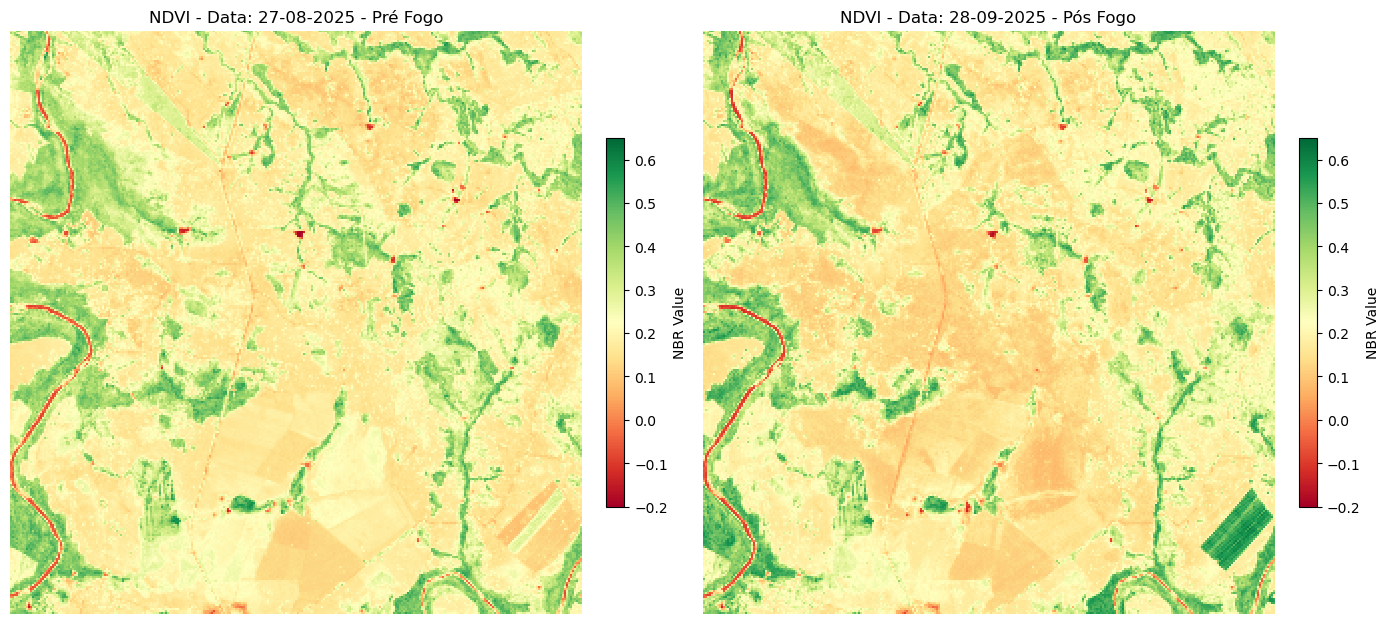

In [93]:
# Configura a figura com dois subplots (1 linha, 2 colunas)
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plota imagem NBR pré-fogo
ndvi_pre_plot = axes[0].imshow(ndvi_pre, cmap="RdYlGn", vmin=-0.2, vmax=0.65, interpolation='nearest')
axes[0].set_title("NDVI - Data: 27-08-2025 - Pré Fogo")
axes[0].axis("off")
cbar_pre = plt.colorbar(ndvi_pre_plot, ax=axes[0], fraction=0.03, pad=0.04)
cbar_pre.set_label("NBR Value")

# Plota imagem NBR pós-fogo
ndvi_pos_plot = axes[1].imshow(ndvi_pos, cmap="RdYlGn", vmin=-0.2, vmax=0.65, interpolation='nearest')
axes[1].set_title("NDVI - Data: 28-09-2025 - Pós Fogo")
axes[1].axis("off")
cbar_pos = plt.colorbar(ndvi_pos_plot, ax=axes[1], fraction=0.03, pad=0.04)
cbar_pos.set_label("NBR Value")

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()

## 📈 Plot Básico - NBR
<hr style="border:1px solid #e69627;">

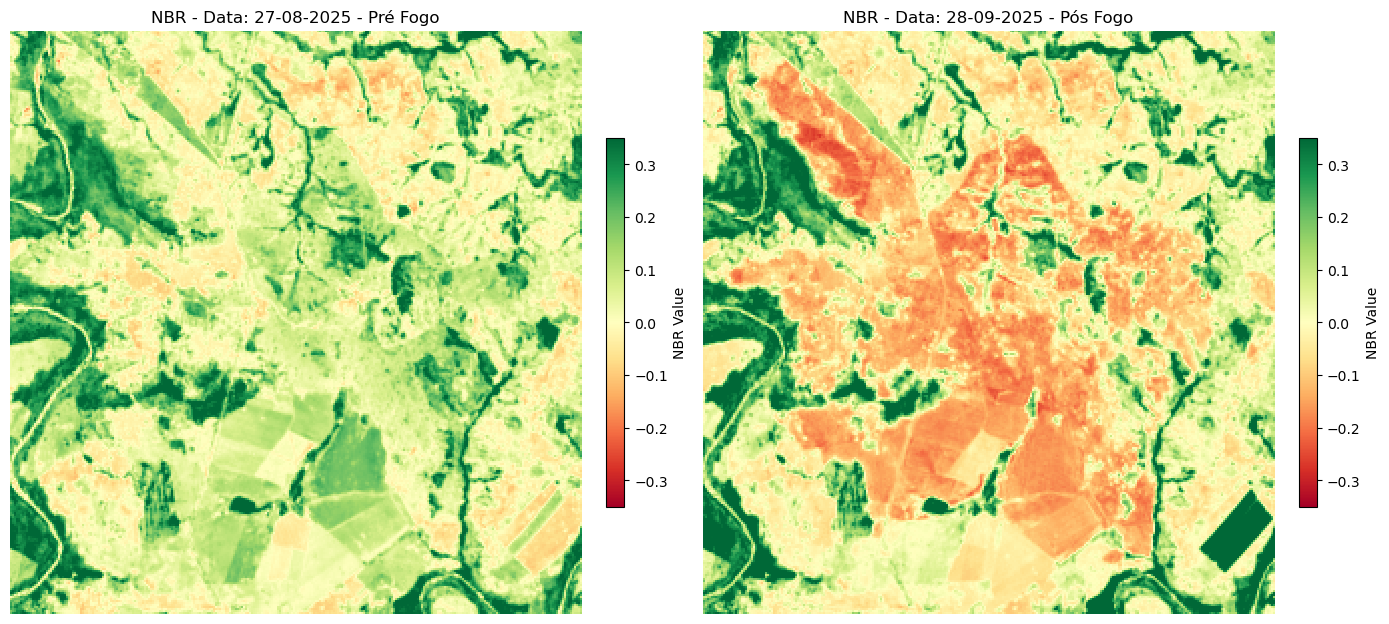

In [94]:
# Configura a figura com dois subplots (1 linha, 2 colunas)
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plota imagem NBR pré-fogo
nbr_pre_plot = axes[0].imshow(nbr_pre, cmap="RdYlGn", vmin=-0.35, vmax=0.35, interpolation='nearest')
axes[0].set_title("NBR - Data: 27-08-2025 - Pré Fogo")
axes[0].axis("off")
cbar_pre = plt.colorbar(nbr_pre_plot, ax=axes[0], fraction=0.03, pad=0.04)
cbar_pre.set_label("NBR Value")

# Plota imagem NBR pós-fogo
nbr_pos_plot = axes[1].imshow(nbr_pos, cmap="RdYlGn", vmin=-0.35, vmax=0.35, interpolation='nearest')
axes[1].set_title("NBR - Data: 28-09-2025 - Pós Fogo")
axes[1].axis("off")
cbar_pos = plt.colorbar(nbr_pos_plot, ax=axes[1], fraction=0.03, pad=0.04)
cbar_pos.set_label("NBR Value")

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()

## 📈 Plot Básico - NBRSWIR
<hr style="border:1px solid #e69627;">

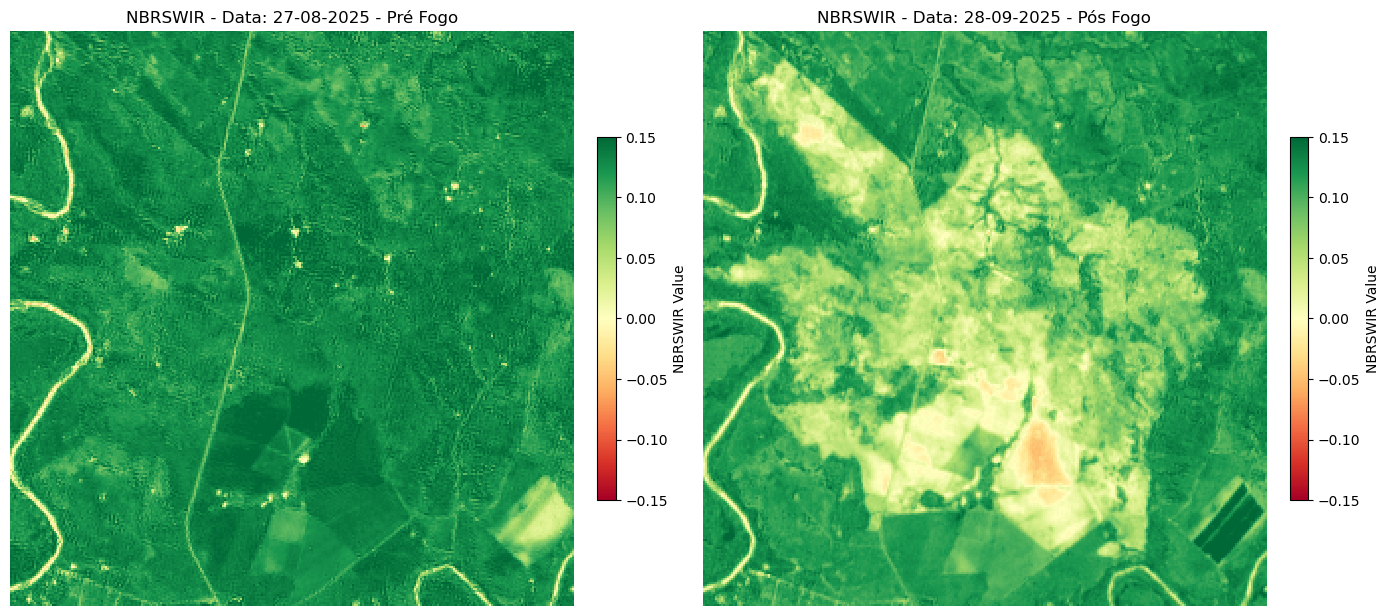

In [95]:
# Configura a figura com dois subplots (1 linha, 2 colunas)
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plota imagem NBR pré-fogo
nbrswir_pre_plot = axes[0].imshow(nbrswir_pre, cmap="RdYlGn", vmin=-0.15, vmax=0.15, interpolation='nearest')
axes[0].set_title("NBRSWIR - Data: 27-08-2025 - Pré Fogo")
axes[0].axis("off")
cbar_pre = plt.colorbar(nbrswir_pre_plot, ax=axes[0], fraction=0.03, pad=0.04)
cbar_pre.set_label("NBRSWIR Value")

# Plota imagem NBR pós-fogo
nbrswir_pos_plot = axes[1].imshow(nbrswir_pos, cmap="RdYlGn", vmin=-0.15, vmax=0.15, interpolation='nearest')
axes[1].set_title("NBRSWIR - Data: 28-09-2025 - Pós Fogo")
axes[1].axis("off")
cbar_pos = plt.colorbar(nbrswir_pos_plot, ax=axes[1], fraction=0.03, pad=0.04)
cbar_pos.set_label("NBRSWIR Value")

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()

# <left><span style="color:#cf4c39">Calculando a área queimada com dNBRSWIR 🧮
<hr style="border:1px solid #e69627;">

## Cálculo da diferença relativa dos índices espectrais das imagens pré-fogo e pós-fogo

In [41]:
# cálculo da diferença relativa dos índices espectrais
ndvi_dif = ndvi_pre - ndvi_pos

nbr_dif = nbr_pre - nbr_pos

nbrswir_dif = nbrswir_pre - nbrswir_pos

In [42]:
print('Apresenta um pequeno recorte de 3 linhas por 3 colunas de dois índices \n')

print('Valores do NDVI pré')
print(ndvi_pre[:3,:3])

print('\n')

print('Valores do NDVI pós')
print(ndvi_pos[:3,:3])

print('\n')

print('Valores de Diferenças do NDVI')
print(ndvi_dif[:3,:3])

Apresenta um pequeno recorte de 3 linhas por 3 colunas de dois índices 

Valores do NDVI pré
[[0.32074152 0.17030568 0.26957727]
 [0.39702233 0.33702422 0.40228341]
 [0.21860061 0.28979592 0.39928134]]


Valores do NDVI pós
[[0.31489071 0.18936877 0.30940241]
 [0.4477782  0.33683842 0.39289208]
 [0.25060048 0.30212929 0.42879197]]


Valores de Diferenças do NDVI
[[ 0.00585081 -0.01906309 -0.03982514]
 [-0.05075587  0.00018581  0.00939133]
 [-0.03199987 -0.01233337 -0.02951064]]


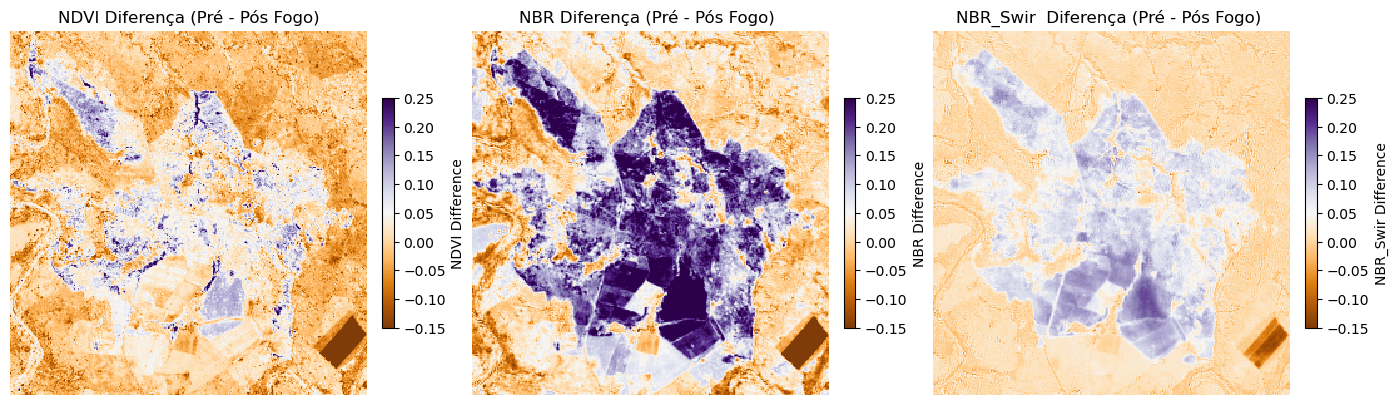

In [43]:
# Configura a figura com dois subplots (1 linha, 3 colunas)
fig, axes = plt.subplots(1, 3, figsize=(14, 7))

# Plota diferença NDVI
ndvi_dif_plot = axes[0].imshow(ndvi_dif, cmap="PuOr", vmin=-0.15, vmax=0.25, interpolation='nearest')
axes[0].set_title("NDVI Diferença (Pré - Pós Fogo)")
axes[0].axis("off")
cbar_ndvi = plt.colorbar(ndvi_dif_plot, ax=axes[0], fraction=0.03, pad=0.04)
cbar_ndvi.set_label("NDVI Difference")

# Plota diferença NBR
nbr_dif_plot = axes[1].imshow(nbr_dif, cmap="PuOr", vmin=-0.15, vmax=0.25, interpolation='nearest')
axes[1].set_title("NBR Diferença (Pré - Pós Fogo) ")
axes[1].axis("off")
cbar_nbr = plt.colorbar(nbr_dif_plot, ax=axes[1], fraction=0.03, pad=0.04)
cbar_nbr.set_label("NBR Difference")

# Plota diferença NBR
nbrswir_dif_plot = axes[2].imshow(nbrswir_dif, cmap="PuOr", vmin=-0.15, vmax=0.25, interpolation='nearest')
axes[2].set_title("NBR_Swir  Diferença (Pré - Pós Fogo) ")
axes[2].axis("off")
cbar_nbr = plt.colorbar(nbrswir_dif_plot, ax=axes[2], fraction=0.03, pad=0.04)
cbar_nbr.set_label("NBR_Swir Difference")

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()

## 💾 Salvando o índice NBRSWIR Diferença no formato GeoTIFF
<hr style="border:1px solid #e69627;">

In [96]:
# Exemplo básico — ajuste conforme seu contexto
height, width = nbr_dif.shape

# Abre o arquivo para escrita
with rasterio.open(
    './output/nbrswir_dif.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,  # número de bandas
    dtype=nbr_dif.dtype,
    crs=ds.crs,  # ex: 'EPSG:4326' ou objeto rasterio.crs.CRS
    transform=box_trasform_20m,
) as dst:
    dst.write(nbrswir_dif, 1)  # escreve na banda 1
    
print("NBRSWIR Diferença  salvo como './output/nbrswir_dif.tif'.")

NBRSWIR Diferença  salvo como './output/nbrswir_dif.tif'.


# <left><span style="color:#cf4c39">Resultados 📊
<hr style="border:1px solid #e69627;">

In [153]:
# Utiliza o método where do numpy para criar uma máscara de 0 e 1

threshold = 0.06 # limiar que veio do qgis

dnbrswir_thres_0_1= np.where(nbrswir_dif>=threshold, 1, 0)

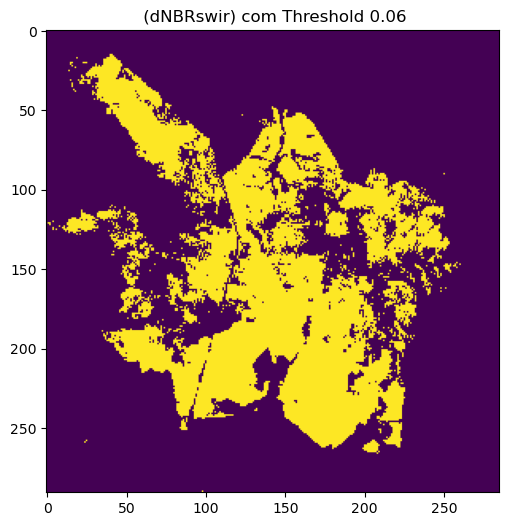

In [155]:
plt.figure(figsize=(10, 6))
plt.imshow(dnbrswir_thres_0_1)
plt.title(" (dNBRswir) com Threshold 0.06")
plt.show()

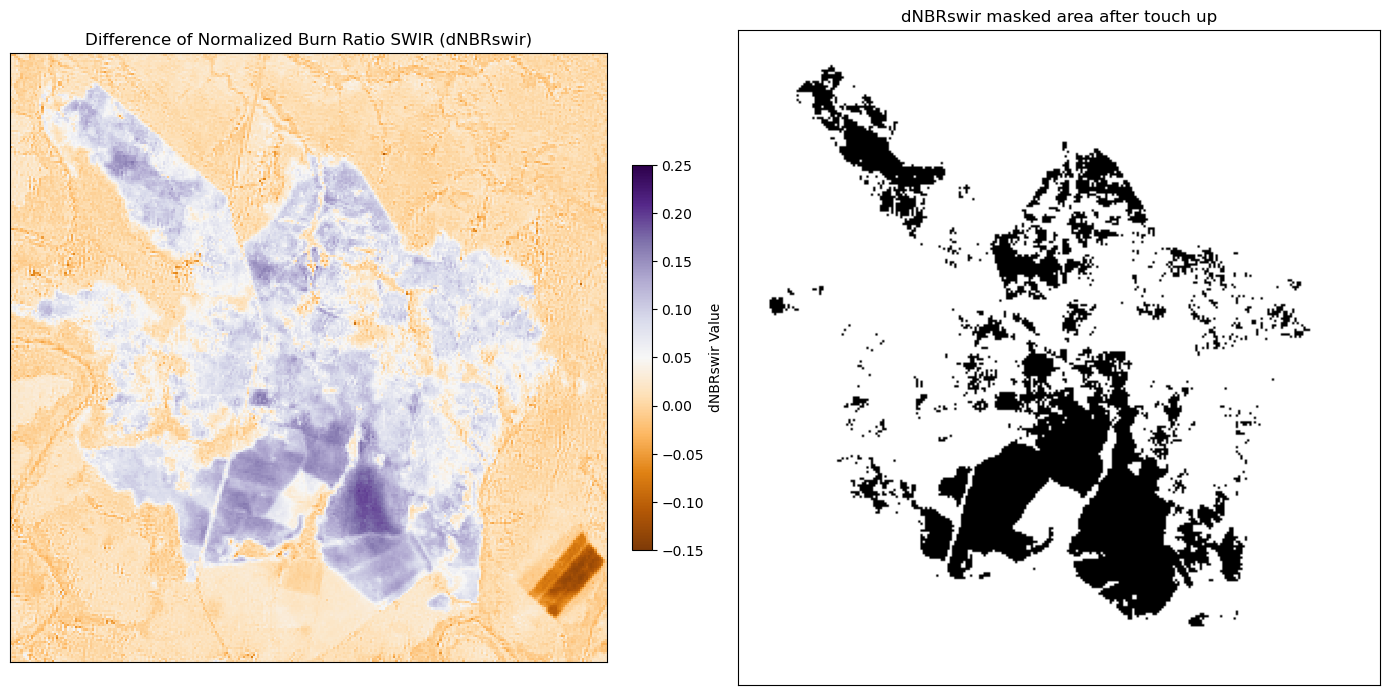

In [47]:
# Cria a figura com dois subplots de igual largura
fig, axes = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [1, 1]})

# Primeiro plot (dNBRswir)
dnbrswir_plot = axes[0].imshow(nbrswir_dif, cmap="PuOr", vmin=-0.15, vmax=0.25, interpolation='nearest')
axes[0].set_title("Difference of Normalized Burn Ratio SWIR (dNBRswir)")
axes[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Colorbar para o primeiro plot
cbar = plt.colorbar(dnbrswir_plot, ax=axes[0], fraction=0.03, pad=0.04)
cbar.set_label("dNBRswir Value")

# Segundo plot (área mascarada)
nbrswir_plot = axes[1].imshow(dnbrswir_thres_0_1, cmap='gray_r')
axes[1].set_title("dNBRswir masked area after touch up")
axes[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

plt.tight_layout()
plt.show()


## Converte a Máscara de formato Raster para Vector e salva em Shapefile

In [87]:

from rasterio.features import shapes
from shapely.geometry import shape

# Converte a máscara para int (0 and 1)
mask_burn = dnbrswir_thres_0_1.astype(np.uint8)

# Converte para poligos
results = shapes(mask_burn, mask=mask_burn == 1, transform=box_trasform_20m)

# Convert para um objeto de geometria da biblioteca shapely
geoms = [shape(geom) for geom, val in results if val == 1]

# Cria um GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=geoms, crs=ds.crs)

# Optional: Add a 'burnt' column for clarity
gdf["queimada"] = 1

# Save to GeoPackage or Shapefile em UTM
gdf.to_file("./output/area_queimada_dnbrswir_utm.shp", driver= "ESRI Shapefile")

# Transforma para EPSG:4326
gdf = gdf.to_crs("EPSG:4326")

# Optional: Add a 'burnt' column for clarity
gdf["queimada"] = 1

# Save to GeoPackage or Shapefile em UTM
gdf.to_file("./output/area_queimada_dnbrswir_wgs84.shp", driver= "ESRI Shapefile")

### Criamos um gráfico que mostra os incêndios detectados sobre a cicatriz de queimada. Os focos de calor detectados são agrupados por dia para ver onde o fogo começou e como se espalhou.

### Evolução dos focos de calor detectações no intervalo de 20/08 a 24/08 de 2024

In [242]:
#!pip install seaborn

Note: you may need to restart the kernel to use updated packages.


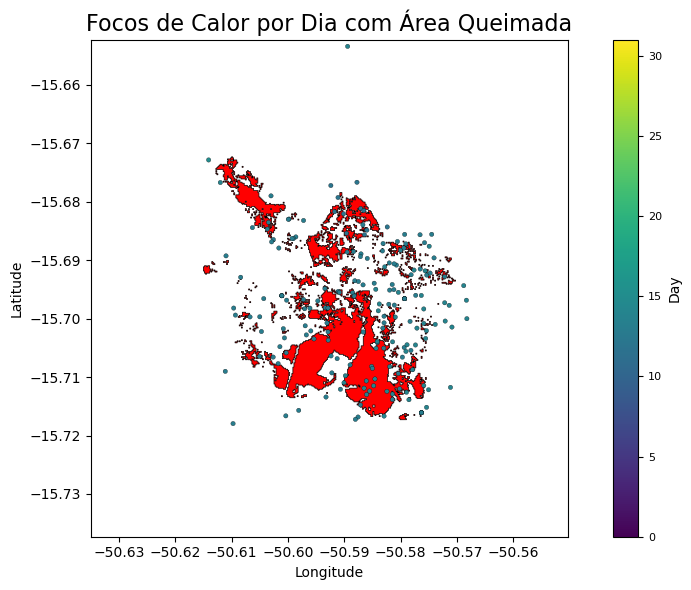

DataHora Satelite    Pais Estado Municipio    Bioma  \
0    2025/08/30 04:21:00  NOAA-21  Brasil  GOIÁS     GOIÁS  Cerrado   
1    2025/08/30 06:30:00  GOES-19  Brasil  GOIÁS     GOIÁS  Cerrado   
2    2025/08/30 06:30:00  GOES-19  Brasil  GOIÁS     GOIÁS  Cerrado   
3    2025/09/01 04:34:00  NOAA-20  Brasil  GOIÁS     GOIÁS  Cerrado   
4    2025/09/02 15:58:00  NOAA-21  Brasil  GOIÁS     GOIÁS  Cerrado   
..                   ...      ...     ...    ...       ...      ...   
558  2025/09/30 16:03:00  NPP-375  Brasil  GOIÁS     GOIÁS  Cerrado   
559  2025/09/30 16:22:00  NOAA-20  Brasil  GOIÁS     GOIÁS  Cerrado   
560  2025/09/30 17:41:00  NPP-375  Brasil  GOIÁS     GOIÁS  Cerrado   
561  2025/09/30 17:41:00  NPP-375  Brasil  GOIÁS     GOIÁS  Cerrado   
562  2025/09/30 17:41:00  NPP-375  Brasil  GOIÁS     GOIÁS  Cerrado   

     DiaSemChuv  Precipitac  RiscoFogo    FRP  Latitude  Longitude  \
0            25        0.48       1.00    1.0 -15.63694  -50.59282   
1            35        1.40       0.98  189.1 -15.76710  -49.97750   
2            26        1.43       1.00  132.9 -15.76760  -49.95550   
3            12        0.10       1.00    1.1 -15.90980  -50.28792   
4             3        0.00       1.00   11.5 -15.82934  -50.01574   
..          ...         ...        ...    ...       ...        ...   
558           5        0.00       0.50    4.8 -15.91961  -49.88745   
559           5        0.00       0.53    7.9 -15.92297  -49.89133   
560           5        0.00       0.64    4.8 -15.78778  -50.31591   
561           5        0.00       0.64    4.3 -15.78813  -50.31786   
562           4        0.00       0.53    3.0 -15.91921  -49.88947   

                        geometry  
0    POINT (-50.59282 -15.63694)  
1      POINT (-49.9775 -15.7671)  
2      POINT (-49.9555 -15.7676)  
3     POINT (-50.28792 -15.9098)  
4    POINT (-50.01574 -15.82934)  
..                           ...  
558  POINT (-49.88745 -15.91961)  
559  POINT (-49.89133 -15.92297)  
560  POINT (-50.31591 -15.78778)  
561  POINT (-50.31786 -15.78813)  
562  POINT (-49.88947 -15.91921)  

[563 rows x 13 columns]

In [88]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Read the DBF file
try:
    gdf = gpd.read_file('./data/queimadas/bdqueimadas_2025-08-29_2025-09-30.dbf')
except FileNotFoundError:
    print("Error: DBF file not found at './data/queimadas/fbdqueimadas_2025-08-29_2025-09-30.dbf'. Please check the file path.")
    exit()


# Step 2: Select relevant columns and ensure they're named correctly
df = gdf[['Longitude', 'Latitude', 'DataHora']].copy()  # Use copy to avoid SettingWithCopyWarning
df = df.dropna(subset=['Longitude', 'Latitude', 'DataHora'])

# Step 2.5: Convert data_hora_ to integer days starting from 0
try:
    df['DataHora'] = pd.to_datetime(df['DataHora'], format='%Y/%m/%d %H:%M:%S')
except ValueError:
    print("Error: Unable to parse 'DataHora' column as datetime. Please check the format.")
    exit()

# Criando a coluna de dias a partir do primeiro dia
df['days'] = (df['DataHora'] - df['DataHora'].min()).dt.days


# Step 3: Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Step 4: Read and plot burnt area polygons
try:
    polygons = gpd.read_file('./output/area_queimada_dnbrswir_wgs84.shp')
    # Transformar para EPSG:4326
    # polygons = polygons.to_crs("EPSG:4326") 
    polygons.plot(ax=ax, color='red', edgecolor='black', linewidth=0.5, alpha=1)
        
except FileNotFoundError:
    print("Warning: Shapefile './input/burnt_area.shp2' not found. Skipping polygon plotting.")

# Step 5: Scatter plot with colormap
scatter = ax.scatter(
    df['Longitude'],
    df['Latitude'],
    c=df['days'],
    cmap='viridis',
    s=10,
    edgecolor='k',
    linewidth=0.2
)

# Step 6: Colorbar
cbar = plt.colorbar(scatter, ax=ax, fraction=0.03, pad=0.04, label='Day')
cbar.ax.tick_params(labelsize=8)

# Step 7: Set axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Focos de Calor por Dia com Área Queimada', fontsize=16)

# Step 8: Set axis limits to the provided bbox

if not polygons.empty:
    minx, miny, maxx, maxy = polygons.total_bounds
    expanded_bbox = box(minx - 0.02, miny - 0.02, maxx + 0.02, maxy + 0.02)  # cria polígono
    minx, miny, maxx, maxy = expanded_bbox.bounds  # extrai bbox do polígono
    
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

plt.tight_layout()
plt.show()

gdf

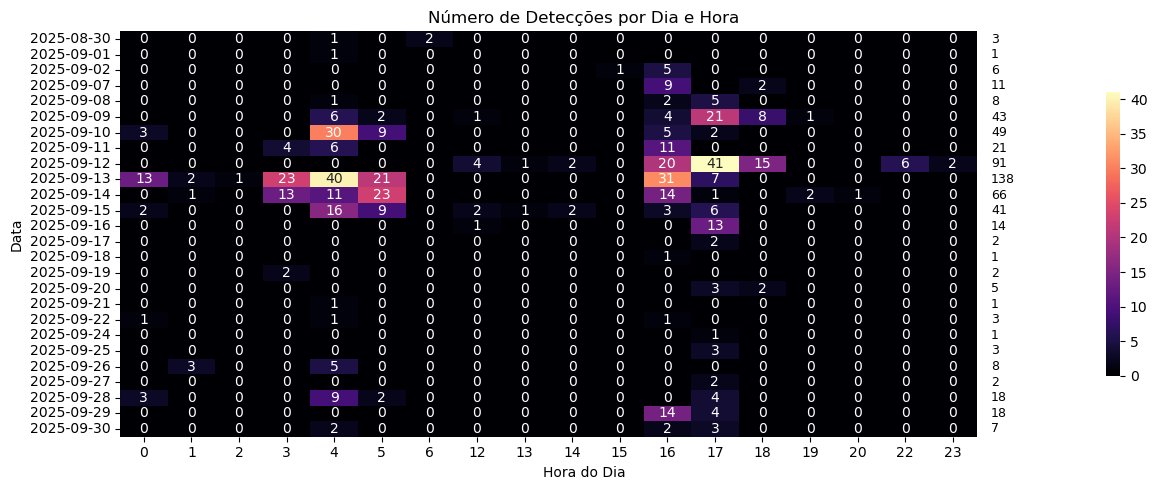

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df['DataHora'] = pd.to_datetime(df['DataHora'])
df['data'] = df['DataHora'].dt.date
df['hora'] = df['DataHora'].dt.hour

heatmap_data = df.groupby(['data', 'hora']).size().unstack(fill_value=0)
totais_por_dia = heatmap_data.sum(axis=1)

fig, ax = plt.subplots(figsize=(13, 5))

sns.heatmap(heatmap_data, cmap='magma', annot=True, fmt='d', ax=ax, cbar_kws={'shrink': 0.7})

ax.set_title('Número de Detecções por Dia e Hora')
ax.set_xlabel('Hora do Dia')
ax.set_ylabel('Data')

# Para alinhar os totais ao lado das linhas do heatmap
for y, total in enumerate(totais_por_dia):
    ax.text(heatmap_data.shape[1] + 0.3, y + 0.5, str(total), va='center', ha='left', fontsize=9, color='black')

# Ajustar limites do eixo x para dar espaço para os números
ax.set_xlim(0, heatmap_data.shape[1] + 1.5)

plt.tight_layout()
plt.show()


In [91]:
# Total de detecções por dia
total_por_dia = df.groupby('data').size().reset_index(name='total_deteccoes')

print(total_por_dia)


          data  total_deteccoes
0   2025-08-30                3
1   2025-09-01                1
2   2025-09-02                6
3   2025-09-07               11
4   2025-09-08                8
5   2025-09-09               43
6   2025-09-10               49
7   2025-09-11               21
8   2025-09-12               91
9   2025-09-13              138
10  2025-09-14               66
11  2025-09-15               41
12  2025-09-16               14
13  2025-09-17                2
14  2025-09-18                1
15  2025-09-19                2
16  2025-09-20                5
17  2025-09-21                1
18  2025-09-22                3
19  2025-09-24                1
20  2025-09-25                3
21  2025-09-26                8
22  2025-09-27                2
23  2025-09-28               18
24  2025-09-29               18
25  2025-09-30                7
